### 导入数据

依然采用之前的数据，使用pandas库进行导入。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/Time\ Series\ Forecasting

/content/drive/MyDrive/Time Series Forecasting


在预处理部分，`1. Data Processing.ipynb`中有详细的操作，这里就不一一介绍了。

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2007,NaN,-26.68,-25.95,NaN,NaN,-29918.592,NaN
1,01/01/2008,NaN,-31.22,-30.45,NaN,NaN,-26686.368,NaN
2,01/01/2009,0.0,-31.96,-31.14,5.2,4.9,-24530.688,2.4
3,01/01/2010,26.5,-29.78,-29.08,8.3,7.9,-25730.784,3.1
4,01/01/2011,0.0,-25.56,-24.82,5.6,5.5,-28958.688,2.5


In [4]:
# 去除缺失值
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# 只保留一列地下水数据
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [5]:
# 简化列名
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']
targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,01/01/2010,26.5,-29.08,8.3,-25730.784,3.1
2,01/01/2011,0.0,-24.82,5.6,-28958.688,2.5
3,01/01/2012,0.0,-27.27,1.5,-35187.264,2.0
4,01/01/2013,0.0,-30.81,1.6,-28532.736,2.5


In [6]:
from datetime import datetime, date 

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

In [7]:
# 对时间戳排序
df = df.sort_values(by='Date')

# 检查时间间隔
df['Time_Interval'] = df.Date - df.Date.shift(1)
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

1 days    4198
Name: Time_Interval, dtype: int64


In [8]:
# 对缺失值进行处理
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

这部分之前都与`1. Data Processing.ipynb`中完全一致。

由于LSTM等深度学习的方法需要较多的训练数据，因而在这里不再对其进行下采样，否则数据量太少。之前的预处理过的数据是经过下采样的，不能直接拿来使用，因而在这里重新对数据进行预处理。

In [9]:
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
138,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
276,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
414,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
552,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


### Dataset的构建

在使用深度学习方法进行训练前，基于pytorch框架，我们通常会先定义一个`Dataset`类，用来加载并处理数据；在训练及评估时，可以调用`DataLoader`类，很方便地读取数据。

In [10]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

给定下标$i$，我们希望我们定义的`Dataset`返回从`i-sequence_length`到`i`的sequence_length行数据。

In [11]:
# 区分目标特征和其余特征
target_feature = "Depth_to_Groundwater"
features = ['Drainage_Volume', 'Rainfall', 'River_Hydrometry', 'Temperature']

# 测试样例数
test_num = 500

# 划分训练集和测试集
df_train = df.iloc[:-test_num].copy()
df_test = df.iloc[-test_num:].copy()

对数据进行标准化处理，否则训练过程中会出问题。

In [12]:
target_mean = df_train[target_feature].mean()
target_stdev = df_train[target_feature].std()

for c in [target_feature] + features:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [13]:
# 测试
i = 100
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target_feature,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

X, y = train_dataset[i+1]
print(X)

print(df_train[features].iloc[(i - sequence_length + 1): (i + 1)])

tensor([[-0.2690, -0.2927,  0.1203, -0.0570],
        [-0.4281, -0.2539, -0.1389, -0.0824],
        [-0.0810, -0.2927, -0.1389, -0.0824],
        [ 0.3000, -0.2927, -0.1389, -0.0697]])
tensor([[-0.4281, -0.2539, -0.1389, -0.0824],
        [-0.0810, -0.2927, -0.1389, -0.0824],
        [ 0.3000, -0.2927, -0.1389, -0.0697],
        [ 1.1724, -0.2927, -0.1389, -0.0063]])
      Drainage_Volume  Rainfall  River_Hydrometry  Temperature
1002        -0.268995 -0.292663          0.120336    -0.057050
1140        -0.428119 -0.253922         -0.138908    -0.082424
1278        -0.080980 -0.292663         -0.138908    -0.082424
1416         0.300010 -0.292663         -0.138908    -0.069737


可以看出，咱们的`Dataset`类是可以按照预期要求返回数据的。

在正式加载数据集的时候，可以利用`DataLoader`类获取数据。

In [14]:
from torch.utils.data import DataLoader
torch.manual_seed(97)

batch_size = 8
sequence_length = 20

train_dataset = SequenceDataset(
    df_train,
    target=target_feature,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target_feature,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([8, 20, 4])
Target shape: torch.Size([8])


### LSTM网络的构建

In [15]:
from torch import nn
from torch.autograd import Variable

class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        
        _, (h_out, _) = self.lstm(x, (h0, c0))
        h_out.view(-1, self.hidden_size)
        out = self.linear(h_out)

        return out

In [16]:
learning_rate = 1e-5
hidden_size = 16

model = TimeSeriesLSTM(input_size=len(features), hidden_size=hidden_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 训练

In [17]:
def train(data_loader, model, loss_function, optimizer, train_loss):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
      output = model(X)
      loss = loss_function(output, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    avg_loss = total_loss / num_batches
    train_loss.append(avg_loss)
    print(f"Train loss: {avg_loss}")

In [18]:
def test(data_loader, model, loss_function, test_loss): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
      for X, y in data_loader:
        output = model(X)
        total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    test_loss.append(avg_loss)
    print(f"Test loss: {avg_loss}")

In [19]:
n_epoch = 50
train_loss = []
test_loss = []
for epoch in range(n_epoch):
  print(f"------------epoch:{epoch+1}------------")
  train(train_loader, model, loss_function, optimizer, train_loss)
  test(test_loader, model, loss_function, test_loss)

------------epoch:1------------


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([1, 8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 1.0375831746868387


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 0.14862614381219452
------------epoch:2------------
Train loss: 1.0300334261219393
Test loss: 0.1432883121541679
------------epoch:3------------
Train loss: 1.0245516002178192
Test loss: 0.13851638364102986
------------epoch:4------------
Train loss: 1.020282542795651
Test loss: 0.13440344742053958
------------epoch:5------------
Train loss: 1.0166943458353468
Test loss: 0.13079375682892055
------------epoch:6------------
Train loss: 1.014323028226908
Test loss: 0.12736186408437788
------------epoch:7------------
Train loss: 1.01584156929288
Test loss: 0.1244651044627452
------------epoch:8------------
Train loss: 1.0105893970758817
Test loss: 0.12154839645344986
------------epoch:9------------
Train loss: 1.0085393629694603
Test loss: 0.11869712010495335
------------epoch:10------------
Train loss: 1.0047333570152972
Test loss: 0.11644843358515082
------------epoch:11------------
Train loss: 1.0038841618768082
Test loss: 0.11412933692733372
------------epoch:12------------


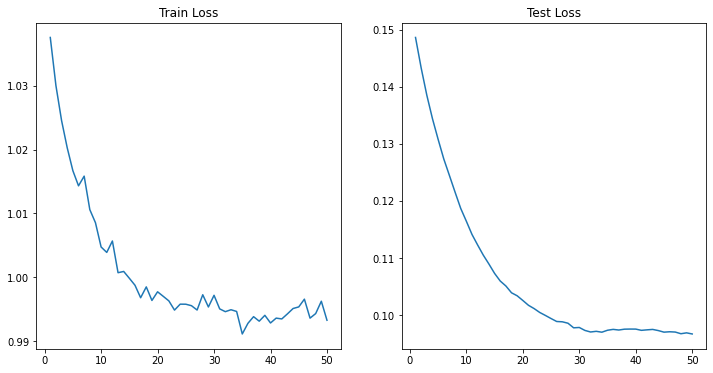

In [20]:
import matplotlib.pyplot as plt
x = range(1, n_epoch+1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x, train_loss)
plt.title("Train Loss")

plt.subplot(1,2,2)
plt.plot(x, test_loss)
plt.title("Test Loss")

plt.show()

我们再更直观地看一下LSTM模型的预测值和真实值的差别。

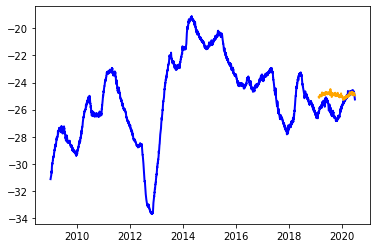

In [21]:
date_x = df.loc[:, "Date"].values
valid_y = df.loc[:, "Depth_to_Groundwater"].values
plt.plot(date_x, valid_y, color="b", label="ground truth", linewidth=2)

pred_y = []

model.eval()
with torch.no_grad():
  for X, y in test_loader:
    output = model(X)
    output = output.flatten().numpy().tolist()
    # 还原成标准化前的数值
    output = [pred*target_stdev+target_mean for pred in output]
    pred_y.extend(output)

plt.plot(date_x[-test_num:], pred_y, color="orange", label="prediction", linewidth=2)

plt.show()